### __Finetuning BERT-large and BERT-large with Whole Word Masking on NLI using LoRA__

Natural Language Inference (NLI) is the task of determining whether a “hypothesis” is true (entailment), false (contradiction), or undetermined (neutral) given a “premise”. For example, given a premise *"A soccer game with multiple males playing"*, a hypothesis *"Some men are playing a sport"* should be entailment, a hypothesis *"A group of men playing cards"* should be a contradiction, while a hypothesis *"The sun is shining"* should be undetermined.

In this notebook, we demonstrate how to finetune BERT-large and BERT-large with whole word masking using LoRA on natural language inference. 

Regular BERT and BERT with Whole Word Masking (WWM) differ primarily in how they mask tokens during pretraining. Regular BERT masks individual subwords generated by the WordPiece tokenizer. For instance, if the word "playing" is tokenized into "play" and "##ing", each token may be masked independently, leading to situations where only part of a word is hidden. In contrast, BERT with WWM masks entire words at once, ensuring that all subword tokens of a given word are masked simultaneously. This difference may lead to variations in how the models learn contextual representations of text.

For example let's consider the sentence: "The quick brown fox jumps over the lazy dog." With WordPiece tokenization, this might be tokenized as: ["The", "quick", "bro", "##wn", "fox", "jump", "##s", "over", "the", "lazy", "dog"].

Assuming "brown" and "jumps" are selected for masking:

|    Method    | Masked Sentence |
|--------------|------------:|
| BERT-style   | The quick [MASK] ##wn fox [MASK] ##s over the lazy dog. |
| Whole Word   | The quick [MASK] [MASK] fox [MASK] [MASK] over the lazy dog. |

Intuitively, BERT with WWM should be generally better suited for tasks like Natural Language Inference (NLI). The intuition stems from the fact that NLI involves understanding complex semantic and syntactic relationships between sentences, which may require deeper comprehension of entire words and their interactions. Whole word masking should allow the model to learn richer, more coherent representation by ensuring that masked words are contextually linked as a whole.

The following example finetunes BERT-large without WWM. The same code was used to finetune a BERT-large model with WWM. To finetune a different model for sequence classification, simply change the `model_checkpoint` to its path or HuggingFace Hub repository. `AutoTokenizer` and `AutoModelForSequenceClassification` classes should automatically detect the model.

#### __Imports__

Below are all Python packages necessary to run this notebook. 

| Python       |     3.10.12 |
|--------------|------------:|
| datasets     |       3.1.0 |
| transformers | 4.47.0.dev0 |
| evaluate     |       0.4.3 |
| peft         |      0.13.2 |
| torch        | 2.5.1+cu121 |
| tensorboard  |      2.18.0 |

In [1]:
from datasets import load_dataset

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer

import evaluate

from peft import LoraConfig
from peft import TaskType
from peft import get_peft_model

import numpy as np

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### __Data Preprocessing__

We will be using the SNLI corpus (version 1.0), a collection of 570k human-written English sentence pairs manually labeled for balanced classification with the labels entailment, contradiction, and neutral, supporting the task of natural language inference (NLI), also known as recognizing textual entailment (RTE). The language in the dataset is English.

In [2]:
# Loading the dataset using huggingface Datasets library

snli = load_dataset("stanfordnlp/snli")

Generating train split: 100%|██████████| 550152/550152 [00:00<00:00, 2247422.15 examples/s]


For each sample in our dataset, there is a string for the premise, a string for the hypothesis, and an integer for the label. Each premise may appear up to three times with a different hypothesis and label.

The SNLI dataset has three splits: *train, validation*, and *test*. All of the examples in the *validation* and *test* sets come from the set that was annotated in the validation task with no-consensus examples removed. The remaining multiply-annotated examples are in the training set with no-consensus examples removed. Each unique premise/caption shows up in only one split, even though they usually appear in at least three different examples.

In [3]:
# Dataset structure

snli

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
})

In [22]:
# Taking a look at one sample.

premises = snli['train']['premise'][0:3]
hypotheses = snli['train']['hypothesis'][0:3]
labels = snli['train']['label'][0:3]

for premise, hypothesis, label in zip(premises, hypotheses, labels):
    print(f'Premise: {premise}\nHypothesis: {hypothesis}\nLabel: {label}')

Premise: A person on a horse jumps over a broken down airplane.
Hypothesis: A person is training his horse for a competition.
Label: 1
Premise: A person on a horse jumps over a broken down airplane.
Hypothesis: A person is at a diner, ordering an omelette.
Label: 2
Premise: A person on a horse jumps over a broken down airplane.
Hypothesis: A person is outdoors, on a horse.
Label: 0


The above sample is an example of three differing hypotheses with the same premise, showing all three possible labels:
 - 0: entailment,
 - 1: neutral / undetermined,
 - 2: contradiction

#### __Data preprocessing__

Preprocessing data includes the removal of invalid labels (some samples have a label of -1) and tokenization of inputs. 

We define two inputs - premise and hypothesis. Accompanying our premise-hypothesis pair is an integer label.

In [4]:
# Loading our tokenizer from a HuggingFace checkpoint

model_checkpoint = "google-bert/bert-large-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [44]:
# Preprocessing function

def preprocess_data(examples):
    hypothesis = [h.strip() for h in examples['hypothesis']]
    premise = [p.strip() for p in examples['premise']]
    label = examples['label']
    
    # Removing samples where label values aren't in defined set
    valid_indices = [i for i, lbl in enumerate(label) if lbl in {0, 1, 2}]
    premise = [premise[i] for i in valid_indices]
    hypothesis = [hypothesis[i] for i in valid_indices]
    label = [label[i] for i in valid_indices]
    
    # Tokenization
    # Truncation is enabled in case of longer samples, however it may not occur at all, as our mean token counts are as follows:
    # Premise: 14.1
    # Hypothesis: 8.3
    inputs = tokenizer(
        premise,
        hypothesis,
        max_length=386, # Max length for truncation, leaving some space for our hypothesis
        truncation='only_first', # Truncating only our premise, as it is generally longer
        stride=64, # Overlapping possibly overflowing samples
        return_overflowing_tokens=False,
        return_offsets_mapping=False,
        return_tensors='pt'
    )
    
    inputs['labels'] = label
    return inputs

In [11]:
# Creating our train, test, and validation datasets using the datasets' map function

train_dataset = snli['train'].map(
    preprocess_data,
    batched=True,
    remove_columns=snli['train'].column_names,
)

val_dataset = snli['validation'].map(
    preprocess_data,
    batched=True,
    remove_columns=snli['validation'].column_names,
)

test_dataset = snli['test'].map(
    preprocess_data,
    batched=True,
    remove_columns=snli['test'].column_names,
)    


Map: 100%|██████████| 10000/10000 [00:00<00:00, 49188.05 examples/s]


In [ ]:
# Checking our datasets

#train_dataset
#test_dataset
val_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 9842
})

As we can see, some samples are removed from our train, test, and validation datasets during our preprocessing step. 

In [13]:
# Creating a data collator 

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, max_length=512)

#### __Finetuning using LoRA__

In [14]:
# Creating our compute metrics function to use in training, using the evaluate library

accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [15]:
# Creating a map of the expected ids to their labels

id2label={0: "entailment", 1: "neutral", 2: "contradiction"}
label2id={"entailment": 0, "neutral": 1, "contradiction": 2}

We initialize our model using HuggingFace's AutoModelForSequenceClassification. This adds a classification head on top of our base language model.

In [16]:
# Model initialization using HuggingFace

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### __Injecting LoRA to our model__

Low-rank Adaptation, or LoRA is a technique that accelerates the fine-tuning of large models while consuming less memory.

To make finetuning more efficient, LoRA's approach is to represent the weight updates with two smaller matrices, called update matrices, through low-rank decomposition. These new matrices can be trained to adapt to the new data while keeping the overall number of changes low. The original weight matrix remains frozen and does not receive any further adjustments. 

In essence, LoRA makes finetuning vastly more efficient by drastically reducing the number of trainable parameters, while retaining model performance comparable to the perfomance of fully finetuned models.

In [17]:
# Creating our LoRA configuration

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8, # Rank of the update matrices. Lower rank results in smaller update matrices with fewer trainable paramters.
    lora_alpha=8, # Controls the magnitude of the updates from the update matrices to the original model parameters, represents the LoRA scaling factor, obtained by dividing lora_alpha by r.
    lora_dropout=0.1,
    bias='all' # Specifies whether should be trained.
)

In [18]:
# Injecting LoRA into our model

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 1,061,891 || all params: 334,371,846 || trainable%: 0.3176


After injecting LoRA into our model, we can see the number of trainable parameters fell from 334M to just 1M. We can increase or decrease the number of trainable parameters by changing the rank of LoRA update matrices (r).

We can train this model as normal, using HuggingFace's TrainingArguments and Trainer API. By defining our output directory in our training arguments, we can monitor model training using TensorBoard. Training time will depend on the number of samples in our dataset, batch sizes, and hardware. In our case we trained on a single NVIDIA A100 for a total of 25312 steps, for approximately 2 hours. 

We calculate our max_steps based on the number of samples, gradient accumulation, and batch size. In our case, our model sees every sample around three times during the course of training, which is equivalent to three epochs of training.

$max\_steps = \frac{num\_samples}{gradient\_accumulation * batch\_size} * n$

In [ ]:
# Defining training arguments for our Trainer

training_args = TrainingArguments(
    output_dir='/shared/home/miha.malensek/transformers/berts_comparison/bert_large',
    learning_rate=2e-5,
    per_device_eval_batch_size=64,
    per_device_train_batch_size=64,
    max_steps=25312, # max_steps = num_samples / (gradient_accumulation * batch_size) (* 3 in our case)
    weight_decay=0.01,
    eval_strategy='steps',
    eval_steps=1000,
    save_strategy='steps',
    save_steps=5000,
    load_best_model_at_end=True,
#    no_cuda=True       # Uncomment for clearer stack trace if encounterng errors
)

In [ ]:
# Initializing the Trainer and training our model

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

To change the model we're finetuning, simply change the model_checkpoint parameter we defined in our data preprocessing step. We can also push our final model to the HuggingFace Hub, using `model.push_to_hub('username/model-repository')`. 

#### __Inference__

In [3]:
from peft import PeftConfig
from peft import PeftModel
import torch

To use our model for inference, load the configuration and model:

In [19]:
#peft_model_id = 'Padajno/bert-large-lora-nli'
peft_model_path = '/shared/home/miha.malensek/transformers/berts_comparison/bert_large_wwm/checkpoint-25312'
config = PeftConfig.from_pretrained(peft_model_path)

# Creating a map of the expected ids to their labels

id2label={0: "entailment", 1: "neutral", 2: "contradiction"}
label2id={"entailment": 0, "neutral": 1, "contradiction": 2}


inference_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path, 
    num_labels=3, 
    id2label=id2label, 
    label2id=label2id
)

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(inference_model, peft_model_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-cased-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prepare some text inputs for our model. Rembember to create a premise and hypothesis, as our model expects two inputs.

In [20]:
premise = "The man is sitting down while typing on his computer."
hypothesis = "The man is standing and reading."

inputs = tokenizer(
    premise,
    hypothesis,
    return_tensors="pt",
    truncation=True,
    padding=True
)

Now we can pass our inputs to the model, and print out the model prediction.

In [21]:
# Passing our inputs to the model

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
# Getting the class with the highest probability, and using the model's id2label mapping to convert it to a text label

prediction = logits.argmax().item()
label = id2label[prediction]
label

'contradiction'

#### __Merging LoRA with our model__

While LoRA is significantly smaller and faster to train, we may encounter some latency issues during inference due to seaprately loading the base model and teh LoRA model. To eliminate latency, we can use the `merge_and_unload()` function to merge our adapter weights with our standalone model, effectively enabling us to use the newly merged model as a standalone model. Furthermore, this standalone model is now also compatible with frameworks such as `pipeline`.

In [23]:
# Merging and saving our model

merged_model = model.merge_and_unload()
merged_model.save_pretrained("/shared/home/miha.malensek/transformers/berts_comparison/bert_large_wwm/merged_model")

In [ ]:
from huggingface_hub import login

login('login-token')
merged_model.push_to_hub('Padajno/bert-large-wwm-lora-nli-merged')

model.safetensors: 100%|██████████| 1.33G/1.33G [00:31<00:00, 42.7MB/s]


CommitInfo(commit_url='https://huggingface.co/Padajno/bert-large-wwm-lora-nli-merged/commit/addb22072b80710a629f5077f799591b94cd1680', commit_message='Upload BertForSequenceClassification', commit_description='', oid='addb22072b80710a629f5077f799591b94cd1680', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Padajno/bert-large-wwm-lora-nli-merged', endpoint='https://huggingface.co', repo_type='model', repo_id='Padajno/bert-large-wwm-lora-nli-merged'), pr_revision=None, pr_num=None)

#### __Evaluation__

In [ ]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_recall_fscore_support

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


In [5]:
# Lets load our models and tokenizers

wwm_bert = AutoModelForSequenceClassification.from_pretrained('Padajno/bert-large-wwm-lora-nli-merged')
bert = AutoModelForSequenceClassification.from_pretrained('Padajno/bert-large-lora-nli-merged')

tokenizer = AutoTokenizer.from_pretrained('/shared/home/miha.malensek/transformers/berts_comparison/bert_large_wwm/checkpoint-25312')

In [15]:
# Selecting the test split of our dataset

test_dataset = snli['test']
test_dataset

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 10000
})

In [ ]:
# Helper function

def compute_metrics(y_true, y_pred, labels):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

def evaluate_model(model, tokenizer, test_data):
    model.to('cuda')
    y_true = []
    y_pred = []
    for example in test_data:
        premise, hypothesis, label = example['premise'], example['hypothesis'], example['label']
        
        if label in {0, 1, 2}:
            inputs = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, padding=True).to('cuda')
            with torch.no_grad():
                logits = model(**inputs).logits
            y_true.append(label)
            y_pred.append(logits.argmax(dim=1).item())
    
    labels = [0, 1, 2]  # SNLI labels: entailment, neutral, contradiction
    metrics = compute_metrics(y_true, y_pred, labels)
    #confidence_intervals = compute_confidence_intervals(y_true, y_pred, labels)
    return metrics
        

In [ ]:
metrics_wwm = []
metrics_bert = []

print("BERT WWM:")
for i in tqdm(range(25)):
    split = test_dataset.train_test_split(test_size=0.5, seed=i)
    metrics = evaluate_model(wwm_bert, tokenizer, split['train'])
    metrics_wwm.append(metrics)
    metrics = evaluate_model(wwm_bert, tokenizer, split['test'])
    metrics_wwm.append(metrics)
print("BERT:")
for i in tqdm(range(25)):
    split = test_dataset.train_test_split(test_size=0.5, seed=i)
    metrics = evaluate_model(bert, tokenizer, split['train'])
    metrics_bert.append(metrics)
    metrics = evaluate_model(bert, tokenizer, split['test'])
    metrics_bert.append(metrics)


BERT WWM:


100%|██████████| 25/25 [42:10<00:00, 101.23s/it]


BERT:


100%|██████████| 25/25 [42:27<00:00, 101.88s/it]


In [ ]:
with open('/shared/home/miha.malensek/transformers/wwm_results.txt', 'w', encoding='utf8') as f:
    for run in metrics_wwm:
        f.write(f'{run}\n')
        
with open('/shared/home/miha.malensek/transformers/bert_results.txt', 'w', encoding='utf8') as f:
    for run in metrics_bert:
        f.write(f'{run}\n')

In [57]:
import json
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
import scipy.stats as stats

In [8]:
wwm_acc = []

wwm_pre = []
wwm_f1 = []
wwm_re = []

def preprocess_line(line):
    line = line.replace('array([', '[').replace('])', ']')
    return line

with open('/shared/home/miha.malensek/transformers/wwm_results.txt', 'r', encoding='utf8') as f:
    for line in f:
        line = preprocess_line(line)
        metric_run = ast.literal_eval(line.strip())
        wwm_acc.append(metric_run['accuracy'])
        wwm_pre.append(metric_run['precision'])
        wwm_re.append(metric_run['recall'])
        wwm_f1.append(metric_run['f1'])

In [13]:
bert_acc = []

bert_pre = []
bert_f1 = []
bert_re = []

def preprocess_line(line):
    line = line.replace('array([', '[').replace('])', ']')
    return line

with open('/shared/home/miha.malensek/transformers/bert_results.txt', 'r', encoding='utf8') as f:
    for line in f:
        line = preprocess_line(line)
        metric_run = ast.literal_eval(line.strip())
        bert_acc.append(metric_run['accuracy'])
        bert_pre.append(metric_run['precision'])
        bert_re.append(metric_run['recall'])
        bert_f1.append(metric_run['f1'])

In [15]:
wacc = np.array(wwm_acc)
wprecision = np.array(wwm_pre)
wrecall = np.array(wwm_re)
wf1 = np.array(wwm_f1)

wmean_accuracy = np.mean(wacc)
wstd_accuracy = np.std(wacc)

wmean_precision = [np.mean(wprecision[0]), np.mean(wprecision[1]), np.mean(wprecision[2])]
wstd_precision = [np.std(wprecision[0]), np.std(wprecision[1]), np.std(wprecision[2])]

wmean_recall = [np.mean(wrecall[0]), np.mean(wrecall[1]), np.mean(wrecall[2])]
wstd_recall = [np.std(wrecall[0]), np.std(wrecall[1]), np.std(wrecall[2])]

wmean_f1 = [np.mean(wf1[0]), np.mean(wf1[1]), np.mean(wf1[2])]
wstd_f1 = [np.std(wf1[0]), np.std(wf1[1]), np.std(wf1[2])]

In [16]:
bacc = np.array(bert_acc)
bprecision = np.array(bert_pre)
brecall = np.array(bert_re)
bf1 = np.array(bert_f1)

bmean_accuracy = np.mean(bacc)
bstd_accuracy = np.std(bacc)

bmean_precision = [np.mean(bprecision[0]), np.mean(bprecision[1]), np.mean(bprecision[2])]
bstd_precision = [np.std(bprecision[0]), np.std(bprecision[1]), np.std(bprecision[2])]

bmean_recall = [np.mean(brecall[0]), np.mean(brecall[1]), np.mean(brecall[2])]
bstd_recall = [np.std(brecall[0]), np.std(brecall[1]), np.std(brecall[2])]

bmean_f1 = [np.mean(bf1[0]), np.mean(bf1[1]), np.mean(bf1[2])]
bstd_f1 = [np.std(bf1[0]), np.std(bf1[1]), np.std(bf1[2])]

In [68]:
print(f"WWM-BERT Accuracy: {wmean_accuracy}, std {wstd_accuracy}\nBERT Accuracy: {bmean_accuracy}, std {bstd_accuracy}")

WWM-BERT Accuracy: 0.8774416891746548, std 0.0032978747197996154
BERT Accuracy: 0.8692998345216217, std 0.003134852046715679


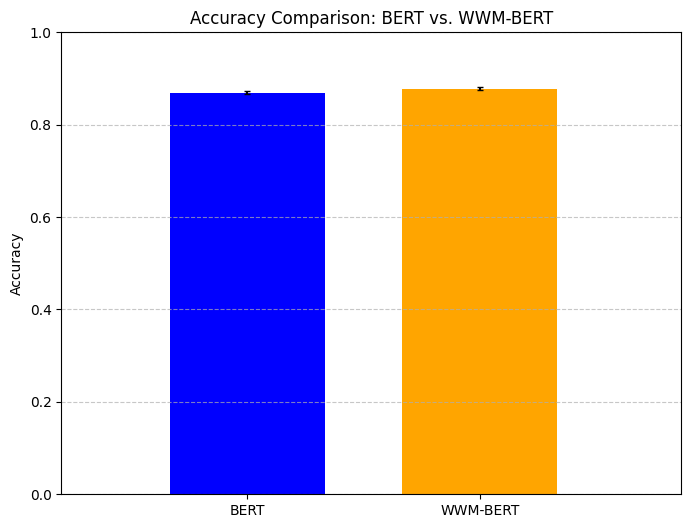

In [63]:

# 1. Plotting the accuracy comparison
fig, ax = plt.subplots(figsize=(8, 6))
models = ['BERT', 'WWM-BERT']
accuracy_means = [bmean_accuracy, wmean_accuracy]
accuracy_stds = [bstd_accuracy, wstd_accuracy]


x_pos = [0.42, 0.57]

ax.bar(x_pos, accuracy_means, yerr=accuracy_stds, capsize=2, color=['blue', 'orange'], width=0.1)
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.set_title('Accuracy Comparison: BERT vs. WWM-BERT')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlim(0.3, 0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
plt.show()

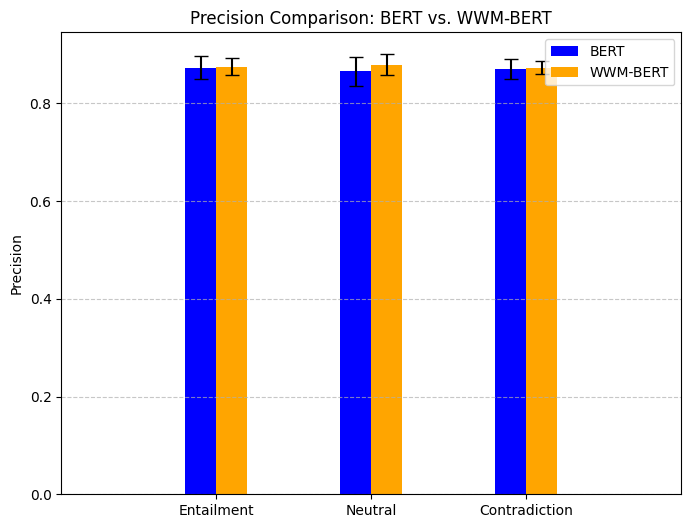

In [64]:
# Bar plot for Precision
fig, ax = plt.subplots(figsize=(8, 6))
classes = ['Entailment', 'Neutral', 'Contradiction']
width = 0.2  # bar width

# Plotting Precision for BERT and WWM-BERT side by side
x = np.arange(len(classes))  # The class positions
ax.bar(x - width/2, bmean_precision, yerr=bstd_precision, width=width, capsize=5, color='blue', label='BERT')
ax.bar(x + width/2, wmean_precision, yerr=wstd_precision, width=width, capsize=5, color='orange', label='WWM-BERT')

ax.set_ylabel('Precision')
ax.set_title('Precision Comparison: BERT vs. WWM-BERT')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.set_xlim(-1, 3)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

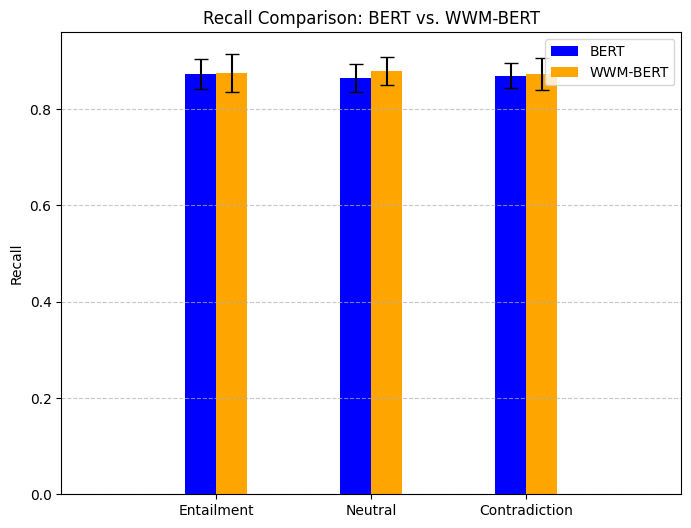

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting Recall for BERT and WWM-BERT side by side
ax.bar(x - width/2, bmean_recall, yerr=bstd_recall, width=width, capsize=5, color='blue', label='BERT')
ax.bar(x + width/2, wmean_recall, yerr=wstd_recall, width=width, capsize=5, color='orange', label='WWM-BERT')

ax.set_ylabel('Recall')
ax.set_title('Recall Comparison: BERT vs. WWM-BERT')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.set_xlim(-1, 3)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

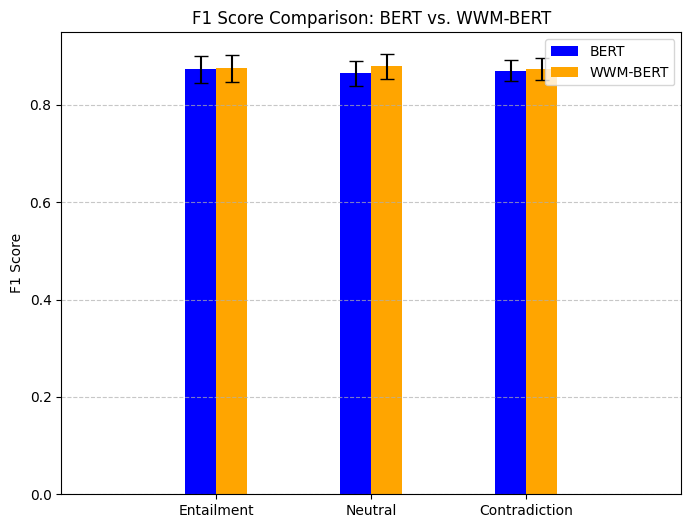

In [66]:
# Bar plot for F1 Score
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting F1 Score for BERT and WWM-BERT side by side
ax.bar(x - width/2, bmean_f1, yerr=bstd_f1, width=width, capsize=5, color='blue', label='BERT')
ax.bar(x + width/2, wmean_f1, yerr=wstd_f1, width=width, capsize=5, color='orange', label='WWM-BERT')

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison: BERT vs. WWM-BERT')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.set_xlim(-1, 3)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()